In [1]:
from vroom.NER import *

In [3]:
def remove_duplicates_by_word(data):
    unique_dicts = []
    words = set()

    for entity in data:
        word = entity['word']
        if word not in words:
            unique_dicts.append(entity)
            words.add(word)

    return unique_dicts

In [4]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import json
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")


##### Process text sample (from wikipedia)

from transformers import pipeline

nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")

with open("../../data/kaggle/les_cavernes_d_acier/chapter_3.txt.preprocessed", "r") as f:
    text = f.read()

data = nlp(text)
# Extract the desired values from each dictionary
filtered_data = [{'entity_group': d['entity_group'], 'word': d['word'], 'start': d['start'], 'end': d['end']} for d in data]
filtered_results = [
        entity for entity in filtered_data if entity["entity_group"] == "PER"
    ]
print(filtered_results)
filtered_results = remove_duplicates_by_word(filtered_results)
#print(type(filtered_results))
print(filtered_results)
# json_data = json.dumps(filtered_results, indent=4, ensure_ascii=False)


# with open('result.json', 'w') as fp:
#     fp.write(json_data)


[{'entity_group': 'PER', 'word': 'Baley', 'start': 91, 'end': 97}, {'entity_group': 'PER', 'word': 'R. Daneel', 'start': 197, 'end': 207}, {'entity_group': 'PER', 'word': 'Baley', 'start': 311, 'end': 317}, {'entity_group': 'PER', 'word': 'Baley', 'start': 797, 'end': 803}]
[{'entity_group': 'PER', 'word': 'Baley', 'start': 91, 'end': 97}, {'entity_group': 'PER', 'word': 'R. Daneel', 'start': 197, 'end': 207}]


In [5]:
test_text = "This is a test text."
tokenized_text = tokenizer.tokenize(test_text)
print(tokenized_text)


['▁This', '▁is', '▁a', '▁test', '▁', 'text', '.']


In [6]:
def chunk_text(text):
    """
    Chunk the text into a list of subtexts of a size of 500 tokens.

    Args:
        text (str): The input text.

    Returns:
        list: A list of subtexts.
    """
    chunked_text = []
    chunk = []
    words = text.split()
    for word in words:
        if len(" ".join(chunk)) + len(word) > 500:
            chunked_text.append(" ".join(chunk))
            chunk = []
        chunk.append(word)
    if chunk:
        chunked_text.append(" ".join(chunk))
    return chunked_text


In [7]:
chunk_text(text)

['avaient créé l’incident de s’en aller ; mais c’était là un inconvénient moins grave... Baley ouvrit la porte en se servant de son passe-partout de policier. A sa vive surprise, il constata que R. Daneel était toujours sur ses talons, et qu’il remettait en poche un autre passe-partout qu’il possédait ; or, Baley dut convenir que cet objet-là était plus petit, mieux fait et plus pratique que celui en usage dans les services de la police new-yorkaise. Le bottier vint à eux, fort agité, et leur dit',
 'd’une voix forte : — Messieurs, c’est la Ville qui m’a imposé ces employés. Je suis absolument dans mon droit. Trois robots se tenaient, raides comme des piquets, au fond du magasin. Six personnes étaient réunies près de la porte ; c’étaient toutes des femmes. — Bon ! dit Baley, sèchement. Alors, qu’est-ce qui ne va pas, et pourquoi tout ce charivari ? Une des femmes lui répondit, d’une voix de tête : — Je suis venue ici acheter des chaussures. Pourquoi ne serais-je pas servie par un vende

In [8]:
def get_entities(text: str):
    """
    Extracts named entities from the given text.

    Args:
        text (str): The input text.

    Returns:
        list: A list of dictionaries representing the named entities. Each dictionary contains the keys 'entity_group',
              'word', 'start', and 'end'.
    """
    tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
    model = AutoModelForTokenClassification.from_pretrained(
        "Jean-Baptiste/camembert-ner"
    )
    nlp = pipeline(
        "ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple"
    )

    raw_result = nlp(text)
    raw_result = [
        {
            "entity_group": entity["entity_group"],
            "word": entity["word"],
            "start": entity["start"],
            "end": entity["end"],
        }
        for entity in raw_result
    ]

    #Only keep the entities that are persons
    filtered_results = [
        entity for entity in raw_result if entity["entity_group"] == "PER"
    ]

    return filtered_results


In [9]:
entities = get_entities(text)
print(entities)

[{'entity_group': 'PER', 'word': 'Baley', 'start': 91, 'end': 97}, {'entity_group': 'PER', 'word': 'R. Daneel', 'start': 197, 'end': 207}, {'entity_group': 'PER', 'word': 'Baley', 'start': 311, 'end': 317}, {'entity_group': 'PER', 'word': 'Baley', 'start': 797, 'end': 803}]


In [10]:
def add_bio_tags(entities):
    for entity in entities:
        word = entity['word']
        bio_tag = ''
        for i, token in enumerate(word.split()):
            if i == 0:
                bio_tag += token + '<B-PER>'
            else:
                bio_tag += ' ' + token + '<I-PER>'
        entity['bio_tag'] = bio_tag
    return entities


In [11]:
add_bio_tags(entities)

[{'entity_group': 'PER',
  'word': 'Baley',
  'start': 91,
  'end': 97,
  'bio_tag': 'Baley<B-PER>'},
 {'entity_group': 'PER',
  'word': 'R. Daneel',
  'start': 197,
  'end': 207,
  'bio_tag': 'R.<B-PER> Daneel<I-PER>'},
 {'entity_group': 'PER',
  'word': 'Baley',
  'start': 311,
  'end': 317,
  'bio_tag': 'Baley<B-PER>'},
 {'entity_group': 'PER',
  'word': 'Baley',
  'start': 797,
  'end': 803,
  'bio_tag': 'Baley<B-PER>'}]

In [12]:
def tag_text(text: str, entities: list):
    """
    Tags the text with BIO tags based on the given entities.

    Args:
        text (str): The input text.
        entities (list): A list of dictionaries representing the named entities. Each dictionary contains the keys 'entity_group',
                          'word', 'start', 'end', and 'bio_tag'.

    Returns:
        str: The tagged text.
    """
    tagged_text = ''
    start = 0
    for entity in entities:
        tagged_text += text[start:entity['start'] + 1] + entity['bio_tag']
        start = entity['end'] + 1
    tagged_text += text[start:]
    return tagged_text

In [13]:
tag_text(text, entities)

'avaient créé l’incident de s’en aller ; mais c’était là un\ninconvénient moins grave...\n     Baley<B-PER>ouvrit la porte en se servant de son passe-partout de\npolicier. A sa vive surprise, il constata que R.<B-PER> Daneel<I-PER>était\ntoujours sur ses talons, et qu’il remettait en poche un autre\npasse-partout qu’il possédait ; or, Baley<B-PER>dut convenir que cet\nobjet-là était plus petit, mieux fait et plus pratique que celui en\nusage dans les services de la police new-yorkaise.\n     Le bottier vint à eux, fort agité, et leur dit d’une voix forte :\n     — Messieurs, c’est la Ville qui m’a imposé ces employés. Je\nsuis absolument dans mon droit.\n     Trois robots se tenaient, raides comme des piquets, au fond\ndu magasin. Six personnes étaient réunies près de la porte ;\nc’étaient toutes des femmes.\n     — Bon ! dit Baley<B-PER> sèchement. Alors, qu’est-ce qui ne va pas,\net pourquoi tout ce charivari ?\n     Une des femmes lui répondit, d’une voix de tête :\n     — Je suis v

In [14]:
def tag_file(input_file_path: str):
    """
    Tags the text in the given file with BIO tags.

    Args:
        input_file_path (str): The path to the input file.

    Returns:
        str: The tagged text.
    """
    with open(input_file_path, 'r') as f:
        text = f.read()

    chunks = chunk_text(text)
    tagged_chunks = []
    for chunk in chunks:
        entities = add_bio_tags(get_entities(chunk))
        tagged_chunks.append(tag_text(chunk, entities))
    return ' '.join(tagged_chunks)

In [15]:
tagged_text = tag_file("../../data/kaggle/les_cavernes_d_acier/chapter_1.txt.preprocessed")

In [16]:
def set_entities_indexes(text_chunks: list, entities: list):
    """
    Sets the start and end indexes of the entities in the joined text.

    Args:
        text_chunks (list): A list of text chunks.
        entities (list): A list of dictionaries representing the named entities. Each dictionary contains the keys 'entity_group',
                          'word', 'start', and 'end'.

    Returns:
        list: A list of dictionaries representing the named entities. Each dictionary contains the keys 'entity_group',
              'word', 'start' and 'end'.
    """
    start = 0
    for chunk in text_chunks:
        for entity in entities:
            entity['start'] += start
            entity['end'] += start
        start += len(chunk) + 1
    return entities

In [17]:
import nltk

def get_cooccurences(text_chunks: list, entities: list):
    """
    Extracts co-occurences from the given text.

    Args:
        chunks_text(list)): The list of subtexts
        entities (list): The list of list of dictionnaries of entities in their given chunk text.

    Returns:
        list: A list of tuples of entities.
    """
    interactions = []
    text = " ".join(text_chunks)
    entities = set_entities_indexes(text_chunks, entities)

    for i in range(len(entities)):
        for j in range(i + 1, len(entities)):
            if(entities[i]["word"] != entities[j]["word"]):
                substring = text[entities[i]["end"]:entities[j]["start"]]
                chunked_substring = nltk.word_tokenize(substring)
                print(chunked_substring)
                if(len(chunked_substring) <= 25):
                    interactions.append((entities[i]["word"], entities[j]["word"]))

    return interactions

In [18]:
with open("../../data/kaggle/les_cavernes_d_acier/chapter_1.txt.preprocessed", "r") as f:
    text = f.read()

chunks = chunk_text(text)
chunk = chunks[9]
entities = get_entities(chunk)
print(entities)
print(chunk)
cooc = get_cooccurences(chunks, entities)
print(cooc)

[{'entity_group': 'PER', 'word': 'Lije', 'start': 4, 'end': 9}, {'entity_group': 'PER', 'word': 'Baley', 'start': 421, 'end': 427}]
oui, Lije. A vrai dire, j’en suis à me demander jusqu’à quel point le vieux monde pourra continuer à supporter les épreuves qui lui sont imposées. Quand j’ai fait installer cette fenêtre, ce n’était pas seulement pour voir le ciel de temps à autre ; c’était pour voir la ville. Je la contemple souvent, et je me demande ce qu’elle va devenir, au cours du prochain siècle ! Ces remarques mélancoliques déplurent vivement à Baley, mais il ne se lassa pas de regarder par la fenêtre, avec une sorte de
[]
[('Lije', 'Baley')]


In [19]:
def write_bio_tag_file(input_file_path: str, output_file_path: str):
    """
    Tags the text in the given file with BIO tags and writes the tagged text to the output file.

    Args:
        input_file_path (str): The path to the input file.
        output_file_path (str): The path to the output file.
    """
    tagged_text = tag_file(input_file_path)
    with open(output_file_path, "w") as f:
        f.write(tagged_text)

In [20]:
from flair.data import Sentence
from flair.models import SequenceTagger

In [21]:
model = SequenceTagger.load("qanastek/pos-french")

with open("test.txt", 'r') as f:
    text = f.read()

sentence = Sentence(text)

# Predict tags
model.predict(sentence)

with open("test" + "_pos.txt", 'w') as file:
    tokens = [token.text for token in sentence.tokens]
    pos_tags = [token.labels[0].value for token in sentence.tokens]

    # Concatenate tokens and POS tags
    result = " ".join([f"{token} <{pos_tag}>" for token, pos_tag in zip(tokens, pos_tags)])

    file.write(result)

2023-12-26 18:41:10,924 SequenceTagger predicts: Dictionary with 69 tags: <unk>, O, DET, NFP, ADJFP, AUX, VPPMS, ADV, PREP, PDEMMS, NMS, COSUB, PINDMS, PPOBJMS, VERB, DETFS, NFS, YPFOR, VPPFS, PUNCT, DETMS, PROPN, ADJMS, PPER3FS, ADJFS, COCO, NMP, PREL, PPER1S, ADJMP, VPPMP, DINTMS, PPER3MS, PPER3MP, PREF, ADJ, DINTFS, CHIF, XFAMIL, PRELFS, SYM, NOUN, MOTINC, PINDFS, PPOBJMP, NUM, PREFP, PDEMFS, VPPFP, PPER3FP


In [22]:
def write_POS_tag_file(input_file_path: str, output_file_path: str):
    """
    Tags the text in the given file with BIO tags and writes the tagged text to the output file.

    Args:
        input_file_path (str): The path to the input file.
        output_file_path (str): The path to the output file.
    """
    with open(input_file_path, 'r') as f:
        text = f.read()

    model = SequenceTagger.load("qanastek/pos-french")
    sentence = Sentence(text)
    model.predict(sentence)

    with open(output_file_path, 'w') as file:
        tokens = [token.text for token in sentence.tokens]
        pos_tags = [token.labels[0].value for token in sentence.tokens]

        result = " ".join([f"{token} <{pos_tag}>" for token, pos_tag in zip(tokens, pos_tags)])

        file.write(result)


In [23]:
write_POS_tag_file("test.txt", "test_POS.txt")

2023-12-26 18:41:17,722 SequenceTagger predicts: Dictionary with 69 tags: <unk>, O, DET, NFP, ADJFP, AUX, VPPMS, ADV, PREP, PDEMMS, NMS, COSUB, PINDMS, PPOBJMS, VERB, DETFS, NFS, YPFOR, VPPFS, PUNCT, DETMS, PROPN, ADJMS, PPER3FS, ADJFS, COCO, NMP, PREL, PPER1S, ADJMP, VPPMP, DINTMS, PPER3MS, PPER3MP, PREF, ADJ, DINTFS, CHIF, XFAMIL, PRELFS, SYM, NOUN, MOTINC, PINDFS, PPOBJMP, NUM, PREFP, PDEMFS, VPPFP, PPER3FP


In [24]:
write_bio_tag_file("../../data/kaggle/les_cavernes_d_acier/chapter_1.txt.preprocessed", "../../data/kaggle/les_cavernes_d_acier/chapter_1.txt.preprocessed.tagged")

In [25]:
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")


nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")

with open("../../data/kaggle/les_cavernes_d_acier/chapter_3.txt.preprocessed", "r") as f:
    text = f.read()

data = nlp(text)
print(data)

[{'entity_group': 'PER', 'score': 0.9974757, 'word': 'Baley', 'start': 91, 'end': 97}, {'entity_group': 'PER', 'score': 0.9821628, 'word': 'R. Daneel', 'start': 197, 'end': 207}, {'entity_group': 'PER', 'score': 0.99788815, 'word': 'Baley', 'start': 311, 'end': 317}, {'entity_group': 'LOC', 'score': 0.94129866, 'word': 'Ville', 'start': 555, 'end': 561}, {'entity_group': 'PER', 'score': 0.9974441, 'word': 'Baley', 'start': 797, 'end': 803}, {'entity_group': 'MISC', 'score': 0.9133416, 'word': 'RO-BOTS', 'start': 1850, 'end': 1858}]


In [2]:
set_determinants("test", "../../vroom/utils/determinants.txt")

['le test',
 'la test',
 'les test',
 "l' test",
 'un test',
 'une test',
 'M test',
 'M.test',
 'Mme test',
 'Mmes test',
 'Mlle test',
 'Mlles test',
 'Mrs test']

In [ ]:
#TODO: tester tous les noms dans un texte pour voir s'il apparaît dedans et s'il n'est pas déjà dans la liste des entités

### Gestion des alias


In [21]:
from transformers import CamembertModel, CamembertTokenizer
import torch

# Load pre-trained Camembert model and tokenizer
model_name = 'camembert-base'
tokenizer = CamembertTokenizer.from_pretrained(model_name)
model = CamembertModel.from_pretrained(model_name)

# List of names that are from the Fondation series
names = ['Gaal Dornick', 'Hari Seldon', 'Salvor Hardin', 'Bel Riose', 'Hober Mallow', 'Preem Palver', 'Eto Demerzel', 'Dors Venabili', 'Wanda Seldon', 'R. Daneel Olivaw', 'Stor Gendibal', 'Janov Pelorat', 'Blissenobiarella', 'Golan Trevize', 'Jole Turbor', 'Pel Orly', 'Daneel Giskard', 'R. Giskard Reventlov', 'R. Daneel Olivaw', 'R. Elijah Baley', 'R. R. Lije Baley', 'R. R. Giskard Baley', 'R. R. Daneel Olivaw', 'R. R. Lodovic Trema']


# Convert names into tokens
tokens = tokenizer(names, return_tensors='pt', padding=True, truncation=True)

# Get embeddings from Camembert
with torch.no_grad():
    embeddings = model(**tokens).last_hidden_state.mean(dim=1)  # Mean pooling over the tokens

# Convert embeddings to a numpy array
embeddings_array = embeddings.numpy()


In [22]:
print(embeddings_array)

[[-2.8835759e-02  1.3267106e-01 -8.3097287e-02 ...  1.2165953e-02
  -1.0069881e-02 -1.9512828e-01]
 [-1.6857621e-04  1.0821990e-01  3.6114737e-02 ... -8.6656928e-02
   3.5277553e-02 -4.4817880e-02]
 [-2.8678095e-02  8.5619025e-02  2.7082525e-02 ... -8.3854966e-02
  -1.6280690e-02 -1.8213565e-02]
 ...
 [ 5.8074716e-02  1.0135769e-01 -1.2888037e-02 ... -7.6477290e-03
  -2.7389582e-03 -4.5718636e-02]
 [ 2.6616780e-02  4.9811576e-02 -5.4434210e-02 ... -2.5353735e-02
  -4.3624233e-02 -6.9716230e-02]
 [ 6.7348517e-03  9.6714862e-02  4.4175338e-02 ...  9.9923881e-03
  -2.5281506e-02 -6.2168729e-02]]


In [23]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
similarity_matrix = cosine_similarity(embeddings_array, embeddings_array)


In [24]:
def create_clusters(similarity_matrix, threshold):
    num_names = similarity_matrix.shape[0]
    clusters = []
    visited = np.zeros(num_names, dtype=bool)

    for i in range(num_names):
        if not visited[i]:
            cluster = [i]
            visited[i] = True

            for j in range(i + 1, num_names):
                if similarity_matrix[i, j] >= threshold:
                    cluster.append(j)
                    visited[j] = True

            clusters.append(cluster)

    return clusters

In [25]:
import numpy as np

clusters = create_clusters(similarity_matrix, 0.80)
print(clusters)
for cluster in clusters:
    print([names[i] for i in cluster])

[[0, 3, 4, 5, 9, 10, 14, 16, 17, 18, 19, 20, 21, 22, 23], [1, 2, 4, 6, 7, 8, 11, 12, 13], [15, 16, 17, 18, 19, 20, 21, 22, 23]]
['Gaal Dornick', 'Bel Riose', 'Hober Mallow', 'Preem Palver', 'R. Daneel Olivaw', 'Stor Gendibal', 'Jole Turbor', 'Daneel Giskard', 'R. Giskard Reventlov', 'R. Daneel Olivaw', 'R. Elijah Baley', 'R. R. Lije Baley', 'R. R. Giskard Baley', 'R. R. Daneel Olivaw', 'R. R. Lodovic Trema']
['Hari Seldon', 'Salvor Hardin', 'Hober Mallow', 'Eto Demerzel', 'Dors Venabili', 'Wanda Seldon', 'Janov Pelorat', 'Blissenobiarella', 'Golan Trevize']
['Pel Orly', 'Daneel Giskard', 'R. Giskard Reventlov', 'R. Daneel Olivaw', 'R. Elijah Baley', 'R. R. Lije Baley', 'R. R. Giskard Baley', 'R. R. Daneel Olivaw', 'R. R. Lodovic Trema']


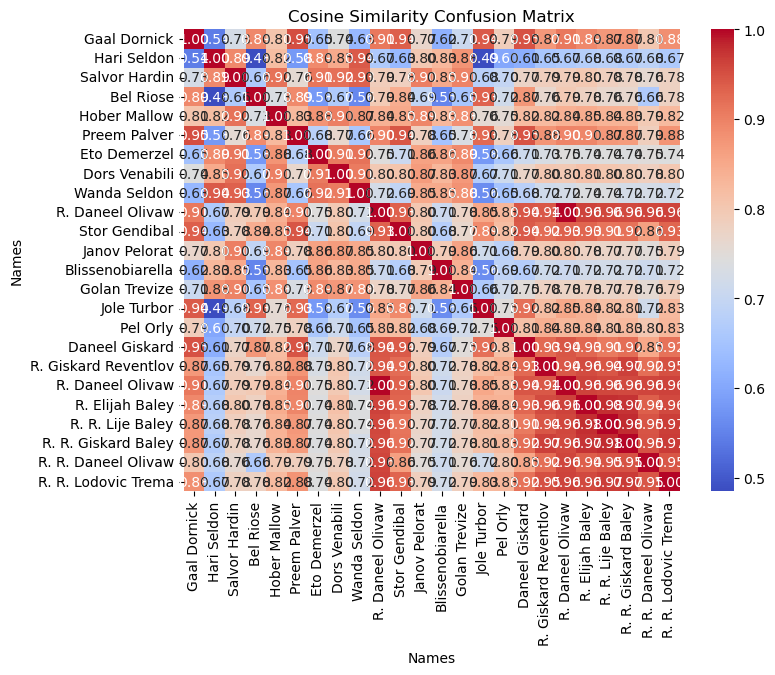

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming similarity_matrix is your cosine similarity matrix
# You can replace it with the actual similarity matrix you have

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=names, yticklabels=names)
plt.title('Cosine Similarity Confusion Matrix')
plt.xlabel('Names')
plt.ylabel('Names')
plt.show()


In [1]:
from vroom.NER import *

entities, chunks = get_entities_from_file("../data/kaggle/les_cavernes_d_acier/chapter_3.txt.preprocessed")

for i in range(len(entities)):
    if(entities[i]["word"] == "l"):
        print(chunks[i])


TypeError: list indices must be integers or slices, not str